# Identifying Spam Text Messages

Notebook to investigate if it is possible to train a machine learning model to identify spam text messages.  Data Sourced from:

http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

In [1]:
#General packages required
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Sklearn packages required for machine learning and model assesment
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB


## Section 1: Read Data File

In [2]:
#Read in text file, parse class and message from each line and store in dictionary
text_messages = {'message':[],'class':[]}

with open('SMSSpamCollection.txt','r') as infile:
    for row in infile:
        text_data = row.split(sep='\t',maxsplit=1)
        text_messages['message'].append(text_data[1][:-2]) #slicing removes \n from the end of each line
        if text_data[0] == 'spam':
            text_messages['class'].append(1)
        else:
            text_messages['class'].append(0)

In [3]:
#Define data X and target attributes y
X = np.array(text_messages['message'])
y = np.array(text_messages['class'])

## Section 2: Exploratory Analysis

Exploratory investigations of the text messages show that there is a prominent difference between the spam and non-spam messages.  They have different grammatical structure, (observable by reading random texts), differing average lengths, (23.9 for spam vs 14.4 for non spam) and have differing word count frequencies (summarised in word clouds).

The difference in average lengths in pronounced, so a statistical test to determine significance has not been carried out.

#### Section 2.1: Defining Useful Function

The following functions are useful for the exploratory analysis of the text messages

In [4]:
def print_messages(message_list,m=3):
    """
    Function to print first 5 values in array
    
    Inputs:
    -------
    message_list: list or pandas array of string values
    m: integer, number of elements to print
    
    """
    for message in message_list[:m]:
        print('-'*90)
        print(message)

In [5]:
def count_tokens(txt_list):
    """Function to count tokens in list of strings"""
        
    count = Counter()
    

    for txt in txt_list:
        tokens = txt.split(sep=' ')

        for token in tokens:
            #if token.lower() not in stop_words:
            count[token.lower()]+=1
                
    output = pd.DataFrame(count.values(),index=count.keys(),columns=['counts']).sort_values('counts',ascending = False)
    
    return output

In [6]:
def plot_word_cloud(txt_list,title = None):
    """
    Function to plot wordclout of inputed list of strings
    """
    to_plot = ' '.join(txt_list)
    
    for a in txt_list:
        to_plot + ' ' + a
    
    wordcloud = WordCloud(width=800,height=400,random_state=42).generate(to_plot)   
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if title != None:
        plt.title(title)
    plt.show()

#### Section 2.2: Text Message Word Counts

In [7]:
examples_spam = X[y==1].copy()
examples_non_spam = X[y==0].copy()

In [8]:
#Total number of text messages
spam_total = len(examples_spam)
non_spam_total = len(examples_non_spam)
print('Number of spam messages:','\t',spam_total)
print('Number of non spam messages:','\t', non_spam_total)
print('Total Number of messages:','\t', non_spam_total+spam_total)

Number of spam messages: 	 747
Number of non spam messages: 	 4827
Total Number of messages: 	 5574


In [9]:
#Calcualte average tokens per message
spam_tokens = count_tokens(examples_spam).sum()
non_spam_tokens = count_tokens(examples_non_spam).sum()
print('Average tokens in spam messages:','\t', '%.2f' % (spam_tokens/spam_total))
print('Average tokens in spam non messages:','\t', '%.2f' % (non_spam_tokens/non_spam_total))
print('Average tokens in all messages:','\t', '%.2f' % ((spam_tokens+non_spam_tokens)/(spam_total+non_spam_total)))

Average tokens in spam messages: 	 23.91
Average tokens in spam non messages: 	 14.40
Average tokens in all messages: 	 15.67


#### Section 2.3: Display Selection Of Text Messages

In [10]:
#Display 3 spam examples
print_messages(examples_spam)

------------------------------------------------------------------------------------------
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18'
------------------------------------------------------------------------------------------
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rc
------------------------------------------------------------------------------------------
WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only


In [11]:
#Display 3 non spam examples
print_messages(examples_non_spam)

------------------------------------------------------------------------------------------
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..
------------------------------------------------------------------------------------------
Ok lar... Joking wif u oni..
------------------------------------------------------------------------------------------
U dun say so early hor... U c already then say..


#### Section 2.4: Wordclouds of Spam and Non Spam Text Messages

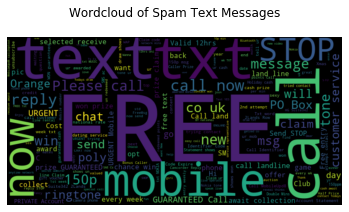

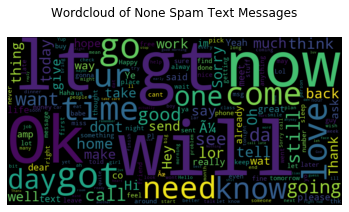

In [12]:
#Plot Wordclouds of Spam and Non Spam messages
plot_word_cloud(examples_spam,title='Wordcloud of Spam Text Messages\n')    
plot_word_cloud(examples_non_spam,title ='Wordcloud of None Spam Text Messages\n')    

## Section 3: Training Machine Learning Model

In [13]:
#Define stopwords list for use in the pipeline
stop_words = stopwords.words('english')

In [14]:
#Define train and test datasets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.35,random_state = 42, stratify=y)

In [15]:
clf_MNB = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())])

In [21]:
param_grid_MNB = {'vect__stop_words':[stop_words,None],
              'vect__ngram_range': [(1,1),(1,2),(1, 3)],
              'tfidf__use_idf': [True, False],
              'clf__alpha':[0.1,0.11,0.15,0.2,0.3]}

In [22]:
%%capture
#Define Gridsearch
GS_clf_MNB = GridSearchCV(clf_MNB,param_grid_MNB,n_jobs=-1,cv=5,return_train_score=True)

#Fit Gridsearch for model
GS_clf_MNB.fit(X_train,y_train)

In [23]:
y_pred_MNB = GS_clf_MNB.predict(X_test)

In [24]:
print(classification_report(y_test,y_pred_MNB))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1690
           1       0.99      0.89      0.93       261

    accuracy                           0.98      1951
   macro avg       0.98      0.94      0.96      1951
weighted avg       0.98      0.98      0.98      1951



In [20]:
confusion_matrix(y_test,y_pred_MNB)

array([[1687,    3],
       [  30,  231]], dtype=int64)